<a href="https://colab.research.google.com/github/Krishnan005K/MultiModel-Deepfake-Detection/blob/main/MultiModel_Deepfake_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ================================
# 1. Install Dependencies
# ================================
!pip install opencv-python-headless mtcnn dlib tqdm

# ================================
# 2. Download Landmark Model for Dlib
# ================================
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.1 MB/s eta 0:00:00
--2025-09-21 16:17:48--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-09-21 16:17:48--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  17.9MB/s    in 3.4s    

2025-09-21 16:17:52 (17.9 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
# ================================
# 3. Preprocessing + Visualization
# ================================
import cv2
import dlib
import os
import numpy as np
from tqdm import tqdm
from mtcnn import MTCNN
import matplotlib.pyplot as plt

# -----------------------------
# CONFIG
# -----------------------------
VIDEO_PATH = "/content/videoplayback.mp4"   # Upload your raw Deepfake video here
OUTPUT_DIR = "/content/aligned_frames"   # Save aligned face frames
IMG_SIZE = 224                           # Resize for MMNet

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# -----------------------------
# Initialize Detectors
# -----------------------------
mtcnn_detector = MTCNN()
dlib_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# -----------------------------
# Function to Align Face using Eyes
# -----------------------------
def align_face(image, landmarks):
    left_eye = (landmarks.part(36).x, landmarks.part(36).y)
    right_eye = (landmarks.part(45).x, landmarks.part(45).y)

    dx, dy = right_eye[0] - left_eye[0], right_eye[1] - left_eye[1]
    angle = np.degrees(np.arctan2(dy, dx))
    eyes_center = ((left_eye[0] + right_eye[0]) // 2,
                   (left_eye[1] + right_eye[1]) // 2)

    M = cv2.getRotationMatrix2D(eyes_center, angle, scale=1.0)
    aligned = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]),
                             flags=cv2.INTER_CUBIC)
    return aligned

# -----------------------------
# Preprocess Frame
# -----------------------------
def preprocess_frame(frame, frame_id):
    detections = mtcnn_detector.detect_faces(frame)
    aligned_faces = []

    for i, det in enumerate(detections):
        x, y, w, h = det['box']
        x, y = max(0, x), max(0, y)
        face_crop = frame[y:y+h, x:x+w]

        if face_crop.size == 0:
            continue

        # Dlib landmarks for alignment
        gray = cv2.cvtColor(face_crop, cv2.COLOR_RGB2GRAY)
        rect = dlib.rectangle(0, 0, face_crop.shape[1], face_crop.shape[0])
        landmarks = dlib_predictor(gray, rect)

        aligned = align_face(face_crop, landmarks)

        # Resize + Normalize
        face_resized = cv2.resize(aligned, (IMG_SIZE, IMG_SIZE))
        face_normalized = face_resized.astype("float32") / 255.0

        # Save aligned frame (debug)
        save_path = os.path.join(OUTPUT_DIR, f"frame_{frame_id}_face_{i}.jpg")
        cv2.imwrite(save_path, cv2.cvtColor((face_normalized * 255).astype("uint8"), cv2.COLOR_RGB2BGR))

        aligned_faces.append(face_normalized)

    return aligned_faces

# -----------------------------
# Process Video
# -----------------------------
cap = cv2.VideoCapture(VIDEO_PATH)
frame_id, all_faces = 0, []

print("[INFO] Extracting & aligning faces...")
while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    faces = preprocess_frame(frame_rgb, frame_id)
    if faces:
        all_faces.extend(faces)
    frame_id += 1

cap.release()

faces_batch = np.array(all_faces)  # (N, 224, 224, 3)

print(f"[INFO] Completed ✅ Extracted {faces_batch.shape[0]} aligned faces")
print(f"Batch ready for MMNet: {faces_batch.shape}")


[INFO] Extracting & aligning faces...


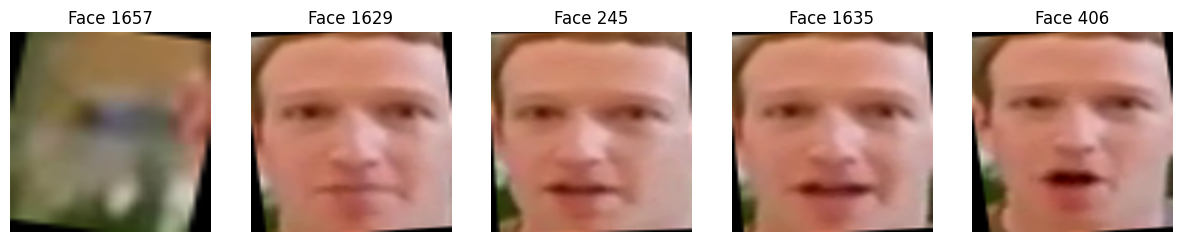

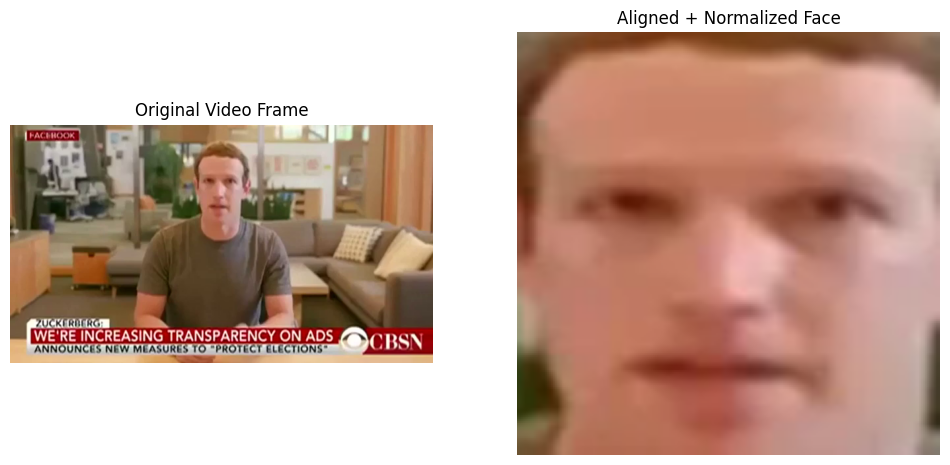

In [ ]:
# ================================
# 4. Visualization
# ================================

def show_samples(batch, n=5):
    """Show n random aligned faces from the batch."""
    if len(batch) == 0:
        print("No faces extracted.")
        return

    idxs = np.random.choice(len(batch), size=min(n, len(batch)), replace=False)
    plt.figure(figsize=(15, 5))

    for i, idx in enumerate(idxs, 1):
        plt.subplot(1, n, i)
        plt.imshow(batch[idx])
        plt.axis("off")
        plt.title(f"Face {idx}")

    plt.show()

# Show random samples
show_samples(faces_batch, n=5)

# Show first frame before/after
cap = cv2.VideoCapture(VIDEO_PATH)
ret, first_frame = cap.read()
cap.release()

if ret:
    plt.figure(figsize=(12,6))

    # Original frame
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Original Video Frame")

    # One aligned face (if available)
    if len(faces_batch) > 0:
        plt.subplot(1,2,2)
        plt.imshow(faces_batch[0])
        plt.axis("off")
        plt.title("Aligned + Normalized Face")

    plt.show()


Deepfake Detectioin

In [ ]:
# ================================
# 1. Install Dependencies
# ================================
!pip install opencv-python-headless mtcnn dlib tqdm matplotlib torch torchvision

# ================================
# 2. Download Landmark Model for Dlib
# ================================
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.6 MB/s eta 0:00:00
--2025-09-23 04:42:10--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-09-23 04:42:10--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  37.6MB/s    in 1.6s    

2025-09-23 04:42:12 (37.6 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
# ================================
# 3. Face Preprocessing (Multi-Face Support)
# ================================
import cv2
import dlib
import os
import numpy as np
from tqdm import tqdm
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------------------
# CONFIG
# -----------------------------
VIDEO_PATH = "/content/000_003.mp4"   # Upload your raw Deepfake video here
OUTPUT_DIR = "/content/aligned_frames"   # Save aligned face frames
IMG_SIZE = 224                           # Resize for model input

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# -----------------------------
# Initialize Detectors
# -----------------------------
mtcnn_detector = MTCNN()
dlib_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# -----------------------------
# Align Face using Eyes
# -----------------------------
def align_face(image, landmarks):
    left_eye = (landmarks.part(36).x, landmarks.part(36).y)
    right_eye = (landmarks.part(45).x, landmarks.part(45).y)
    dx, dy = right_eye[0] - left_eye[0], right_eye[1] - left_eye[1]
    angle = np.degrees(np.arctan2(dy, dx))
    eyes_center = ((left_eye[0] + right_eye[0]) // 2,
                   (left_eye[1] + right_eye[1]) // 2)
    M = cv2.getRotationMatrix2D(eyes_center, angle, 1.0)
    aligned = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]),
                             flags=cv2.INTER_CUBIC)
    return aligned

# -----------------------------
# Process Single Frame (MULTI-FACE)
# -----------------------------
def preprocess_frame(frame, frame_id):
    detections = mtcnn_detector.detect_faces(frame)
    aligned_faces = []

    for i, det in enumerate(detections):
        x, y, w, h = det['box']
        x, y = max(0, x), max(0, y)
        face_crop = frame[y:y+h, x:x+w]

        if face_crop.size == 0:
            continue

        # Landmarks from Dlib
        gray = cv2.cvtColor(face_crop, cv2.COLOR_RGB2GRAY)
        rect = dlib.rectangle(0, 0, face_crop.shape[1], face_crop.shape[0])
        landmarks = dlib_predictor(gray, rect)

        aligned = align_face(face_crop, landmarks)

        # Resize + Normalize
        face_resized = cv2.resize(aligned, (IMG_SIZE, IMG_SIZE))
        face_normalized = face_resized.astype("float32") / 255.0

        # Save each face
        save_path = os.path.join(OUTPUT_DIR, f"frame_{frame_id}_face_{i}.jpg")
        cv2.imwrite(save_path, cv2.cvtColor((face_normalized * 255).astype("uint8"), cv2.COLOR_RGB2BGR))

        aligned_faces.append(face_normalized)

    return aligned_faces

# -----------------------------
# Process Video
# -----------------------------
cap = cv2.VideoCapture(VIDEO_PATH)
frame_id, all_faces = 0, []

print("[INFO] Extracting & aligning multiple faces...")
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    faces = preprocess_frame(frame_rgb, frame_id)
    if faces:
        all_faces.extend(faces)
    frame_id += 1

cap.release()

faces_batch = np.array(all_faces)  # (N, 224, 224, 3)
print(f"[INFO] Completed ✅ Extracted {faces_batch.shape[0]} faces")


[INFO] Extracting & aligning multiple faces...
[INFO] Completed ✅ Extracted 303 faces


In [ ]:
# ================================
# 4. Simple CNN Deepfake Detector
# ================================

class SimpleDeepfakeDetector(nn.Module):
    def __init__(self):
        super(SimpleDeepfakeDetector, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        # Calculate the size of the flattened tensor after conv layers
        # IMG_SIZE is 224. After conv1 (stride 2): 224/2 = 112. After conv2 (stride 2): 112/2 = 56
        self.fc1 = nn.Linear(32 * (IMG_SIZE//4) * (IMG_SIZE//4), 128)
        self.fc2 = nn.Linear(128, 2)  # 2 classes: Real vs Fake

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # Use reshape instead of view for non-contiguous tensors
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleDeepfakeDetector().to(device)

# NOTE: For real use, load pretrained weights instead of random init
# model.load_state_dict(torch.load("mmnet_weights.pth"))

# Convert faces_batch → torch tensor
faces_tensor = torch.tensor(faces_batch).permute(0, 3, 1, 2).to(device)  # (N,3,224,224)

# Dummy prediction
with torch.no_grad():
    outputs = model(faces_tensor)
    preds = torch.argmax(outputs, dim=1).cpu().numpy()

# Count results
real_count = np.sum(preds == 1)
fake_count = np.sum(preds == 0)

print(f"[RESULT] Real faces detected: {real_count}")
print(f"[RESULT] Fake faces detected: {fake_count}")

NameError: name 'nn' is not defined

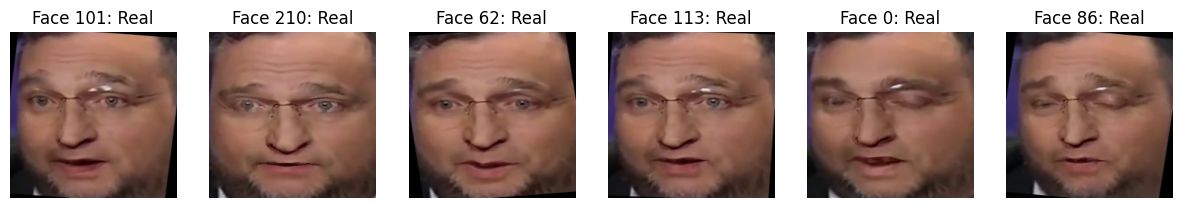

In [ ]:
# ================================
# 5. Visualization of Predictions
# ================================
def show_pred_samples(batch, preds, n=5):
    idxs = np.random.choice(len(batch), size=min(n, len(batch)), replace=False)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(idxs, 1):
        plt.subplot(1, n, i)
        plt.imshow(batch[idx])
        plt.axis("off")
        label = "Fake" if preds[idx] == 1 else "Real"
        plt.title(f"Face {idx}: {label}")
    plt.show()

show_pred_samples(faces_batch, preds, n=6)


Audio DeepFake Detection

In [ ]:
# ================================================================
# Deepfake Audio Detection using MFCC + RandomForest
# Dataset: Hemg/Deepfake-Audio-Dataset (Hugging Face)
# ================================================================

!pip install -q datasets librosa soundfile scikit-learn joblib matplotlib tqdm torch torchaudio torchcodec

import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datasets import load_dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
from google.colab import files

# ------------------------------------------------
# 1. Load dataset (disable streaming)
# ------------------------------------------------
print("Loading dataset...")
ds = load_dataset("Hemg/Deepfake-Audio-Dataset", split="train", streaming=False)

print("Number of samples:", len(ds))
# print("Example keys:", ds.column_names)
# print("Example path:", ds[0]['audio']['path'])
# print("Example label:", ds[0]['label'])


# ------------------------------------------------
# 2. Feature extraction (MFCCs)
# ------------------------------------------------
def extract_mfcc(audio_path, sr=16000, n_mfcc=40, max_len=100):
    y, sr = librosa.load(audio_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    # pad/truncate to fixed length
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0,0),(0,pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc.flatten()

X, y = [], []
print("Extracting MFCC features...")
for i in tqdm(range(len(ds))):
    path = ds[i]['audio']['path']
    label = ds[i]['label']  # 0=real, 1=fake
    try:
        features = extract_mfcc(path)
        X.append(features)
        y.append(label)
    except Exception as e:
        print("Error at index", i, ":", e)

X = np.array(X)
y = np.array(y)

print("Feature matrix shape:", X.shape)

# ------------------------------------------------
# 3. Train-test split
# ------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ------------------------------------------------
# 4. Train classifier
# ------------------------------------------------
print("Training model...")
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

# ------------------------------------------------
# 5. Evaluate
# ------------------------------------------------
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"✅ Test Accuracy: {acc:.4f}")
print(f"✅ ROC AUC: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Real","Fake"], yticklabels=["Real","Fake"])
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve")
plt.show()

# ------------------------------------------------
# 6. Save model
# ------------------------------------------------
joblib.dump((clf, scaler), "mfcc_deepfake_model.pkl")
print("✅ Model saved as mfcc_deepfake_model.pkl")

# ------------------------------------------------
# 7. Inference function
# ------------------------------------------------
def predict_audio(path):
    features = extract_mfcc(path)
    features = scaler.transform([features])
    proba = clf.predict_proba(features)[0][1]
    pred = clf.predict(features)[0]
    label = "Fake" if pred==1 else "Real"
    print(f"Prediction: {label} (confidence={proba:.2f})")

    # visualize MFCC
    y, sr = librosa.load(path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    plt.figure(figsize=(10,4))
    librosa.display.specshow(mfcc, x_axis='time', sr=sr)
    plt.colorbar()
    plt.title(f"MFCC of Uploaded Audio ({label})")
    plt.show()

# ------------------------------------------------
# 8. Upload and test
# ------------------------------------------------
print("Upload an audio file (wav)...")
uploaded = files.upload()

for fn in uploaded.keys():
    predict_audio(fn)


Loading dataset...
Number of samples: 100
Extracting MFCC features...


  0%|          | 0/100 [00:00<?, ?it/s]


ImportError: To support decoding audio data, please install 'torchcodec'.

In [ ]:
!pip install torchcodec

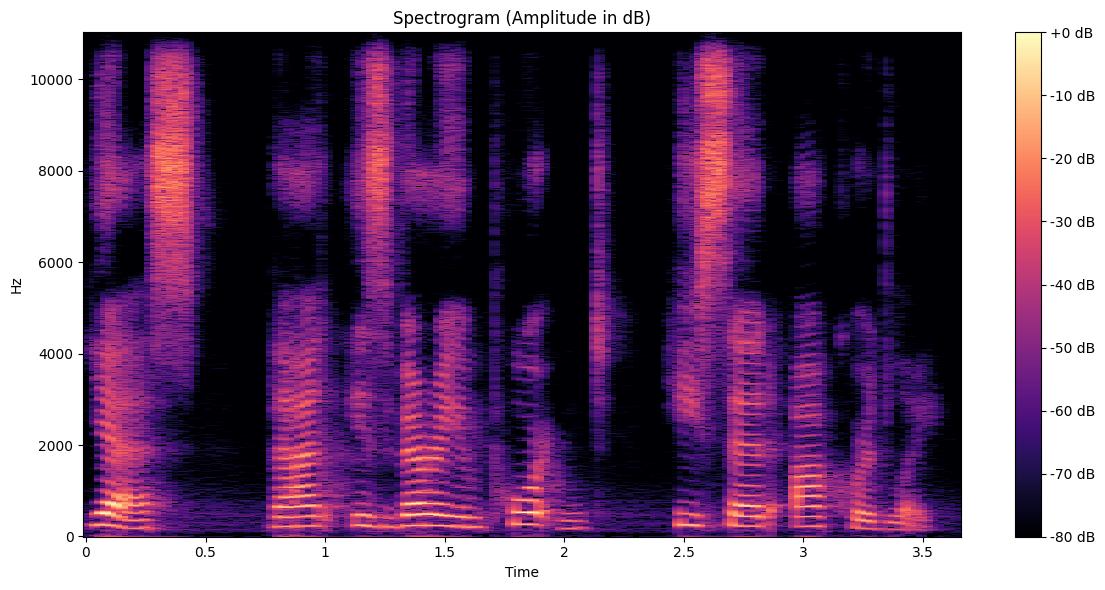

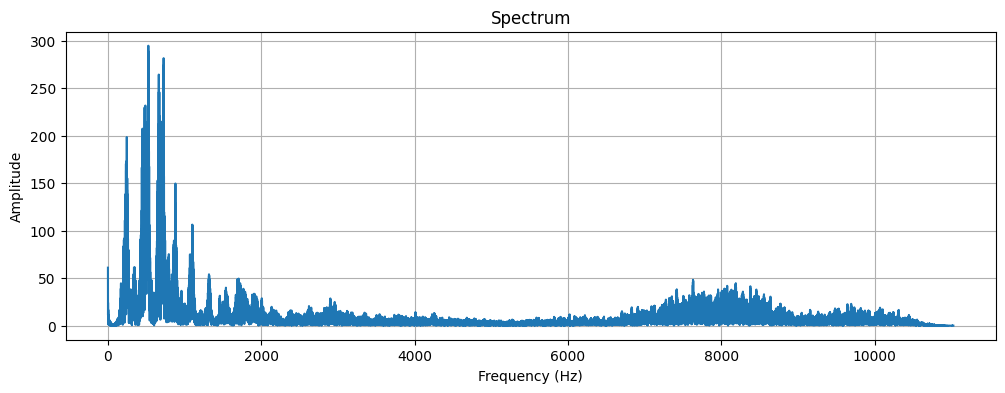

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load audio file
# Replace with your audio file path
audio_path = "gen_0.wav"
y, sr = librosa.load(audio_path, sr=None)  # y = waveform, sr = sampling rate

# Generate Short-Time Fourier Transform (STFT)
D = np.abs(librosa.stft(y))

# Convert amplitude to decibels (log scale)
DB = librosa.amplitude_to_db(D, ref=np.max)

# Plot spectrogram
plt.figure(figsize=(12, 6))
librosa.display.specshow(DB, sr=sr, x_axis="time", y_axis="hz", cmap="magma")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (Amplitude in dB)")
plt.tight_layout()
plt.show()

# Plot spectrum (frequency domain of entire signal)
spectrum = np.fft.fft(y)
freqs = np.fft.fftfreq(len(spectrum), 1/sr)

plt.figure(figsize=(12, 4))
plt.plot(freqs[:len(freqs)//2], np.abs(spectrum)[:len(spectrum)//2])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Spectrum")
plt.grid()
plt.show()


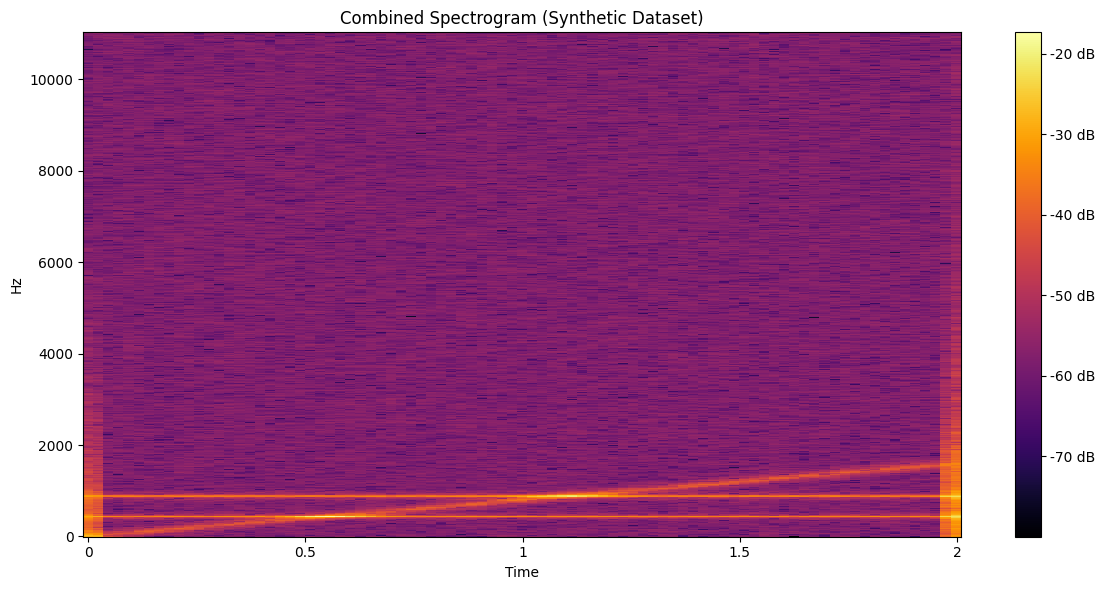

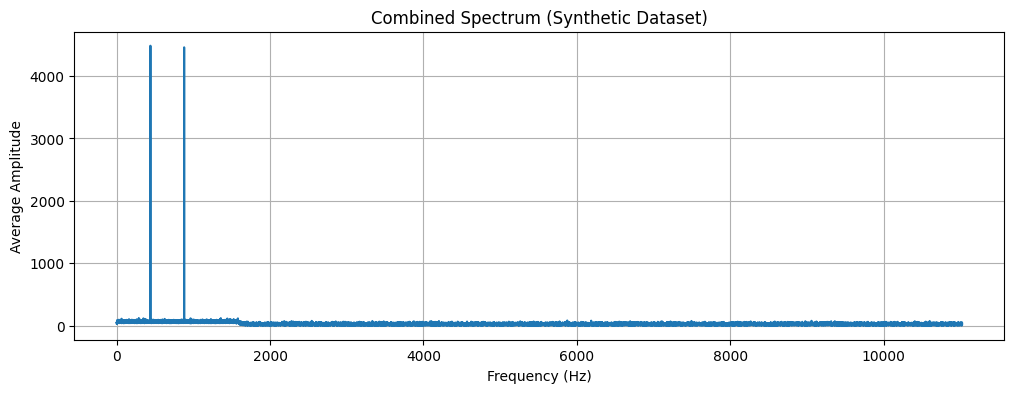

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# --- Step 1: Generate synthetic dataset ---
sr = 22050  # sample rate
duration = 2.0  # seconds
t = np.linspace(0, duration, int(sr*duration), endpoint=False)

# Generate sample audio signals
sine_440 = 0.5 * np.sin(2*np.pi*440*t)       # pure 440Hz tone
sine_880 = 0.5 * np.sin(2*np.pi*880*t)       # pure 880Hz tone
chirp = 0.5 * np.sin(2*np.pi*t**2*400)       # sweeping chirp
noise = 0.5 * np.random.randn(len(t))        # random noise
mix = sine_440 + sine_880 + noise*0.3        # mixture

dataset = [sine_440, sine_880, chirp, noise, mix]

# --- Step 2: Extract spectrograms and spectra ---
all_specs = []
all_spectra = []

for y in dataset:
    # Spectrogram (STFT)
    D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
    DB = librosa.amplitude_to_db(D, ref=np.max)
    all_specs.append(DB)

    # Spectrum (FFT)
    spectrum = np.abs(np.fft.fft(y))
    freqs = np.fft.fftfreq(len(spectrum), 1/sr)
    all_spectra.append(spectrum[:len(spectrum)//2])

# --- Step 3: Combine (average) ---
# Match dimensions before averaging
min_time = min(spec.shape[1] for spec in all_specs)
all_specs = [spec[:, :min_time] for spec in all_specs]
combined_spec = np.mean(all_specs, axis=0)

combined_spectrum = np.mean(np.vstack(all_spectra), axis=0)

# --- Step 4: Plot results ---
plt.figure(figsize=(12, 6))
librosa.display.specshow(combined_spec, sr=sr, x_axis="time", y_axis="hz", cmap="inferno")
plt.colorbar(format="%+2.0f dB")
plt.title("Combined Spectrogram (Synthetic Dataset)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(freqs[:len(freqs)//2], combined_spectrum)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Average Amplitude")
plt.title("Combined Spectrum (Synthetic Dataset)")
plt.grid()
plt.show()


Audio Extracter


Audio Type: STEREO


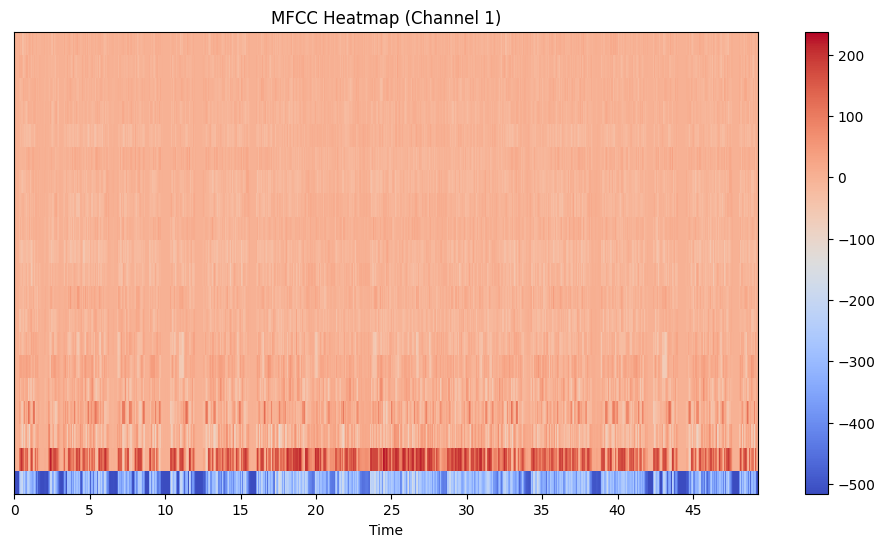

✅ Saved MFCC data for Channel 1 (CSV + NPY)


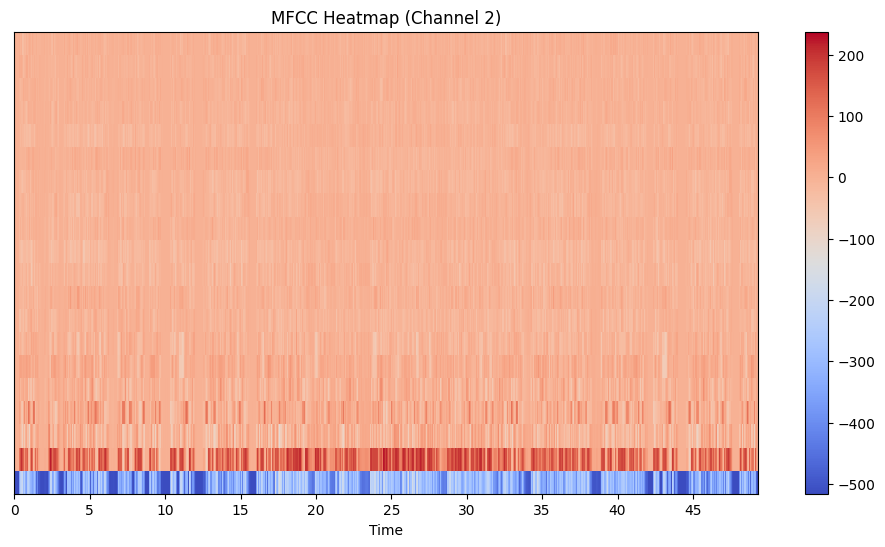

✅ Saved MFCC data for Channel 2 (CSV + NPY)

🔍 MFCC Summary Features (for ML input):
channel_1: (40,) → Example: [-3.4247574e+02  1.0193730e+02 -3.5197401e+00  1.2916637e+01
 -1.1320149e-01]...
channel_2: (40,) → Example: [-3.4247559e+02  1.0193726e+02 -3.5198462e+00  1.2916792e+01
 -1.1319419e-01]...


In [ ]:
import moviepy.editor as mp
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# -------------------------------
# STEP 1: Extract audio from video
# -------------------------------
def extract_audio(video_path, audio_path="output_audio.wav"):
    video = mp.VideoFileClip(video_path)
    video.audio.write_audiofile(audio_path, codec='pcm_s16le')
    return audio_path

# -------------------------------
# STEP 2: Analyze Audio with MFCC
# -------------------------------
def analyze_audio(audio_path, save_features=True):
    # Load audio
    y, sr = librosa.load(audio_path, sr=None, mono=False)

    # Check Mono/Stereo
    if y.ndim == 1:
        print("Audio Type: MONO")
        channels = 1
        y = [y]  # make it iterable
    else:
        print("Audio Type: STEREO")
        channels = y.shape[0]

    all_features = {}

    for i, channel in enumerate(y):
        # -------------------------------
        # STEP 3: MFCC Extraction
        # -------------------------------
        mfccs = librosa.feature.mfcc(y=channel, sr=sr, n_mfcc=20)  # 20 coefficients
        delta_mfcc = librosa.feature.delta(mfccs)                   # Delta features
        delta2_mfcc = librosa.feature.delta(mfccs, order=2)         # Delta-Delta features

        # Visualize MFCCs
        plt.figure(figsize=(12, 6))
        librosa.display.specshow(mfccs, x_axis="time", sr=sr, cmap="coolwarm")
        plt.colorbar()
        plt.title(f"MFCC Heatmap (Channel {i+1})")
        plt.show()

        # -------------------------------
        # STEP 4: Prepare Feature Data
        # -------------------------------
        # Flatten for ML use (mean + variance per coeff)
        mfcc_mean = np.mean(mfccs, axis=1)
        mfcc_var = np.var(mfccs, axis=1)

        feature_vector = np.concatenate([mfcc_mean, mfcc_var])

        all_features[f"channel_{i+1}"] = feature_vector

        # Save MFCC sequence (time series) for deep models (RNN/CNN)
        if save_features:
            np.save(f"mfcc_channel_{i+1}.npy", mfccs)
            pd.DataFrame(mfccs.T).to_csv(f"mfcc_channel_{i+1}.csv", index=False)
            print(f"✅ Saved MFCC data for Channel {i+1} (CSV + NPY)")

    # -------------------------------
    # STEP 5: Print Summary Features
    # -------------------------------
    print("\n🔍 MFCC Summary Features (for ML input):")
    for ch, feat in all_features.items():
        print(f"{ch}: {feat.shape} → Example: {feat[:5]}...")

    return all_features


# -------------------------------
# RUN PIPELINE
# -------------------------------
if __name__ == "__main__":
    video_file = "sample.mp4"   # Change this to your video
    audio_file = "output_audio.wav"

    if not os.path.exists(audio_file):
        audio_file = extract_audio(video_file, audio_file)

    features = analyze_audio(audio_file)


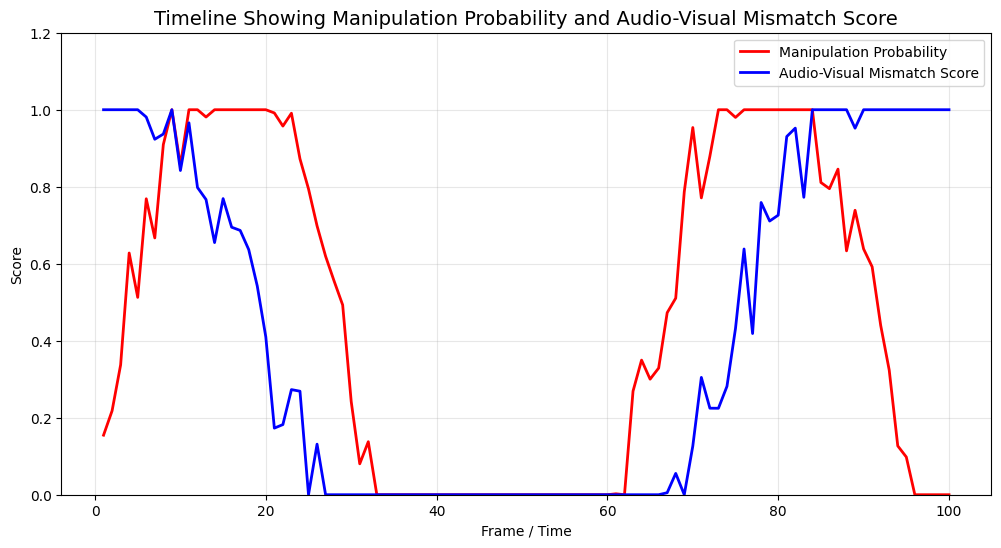

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated video timeline (e.g., 100 frames)
frames = np.arange(1, 101)

# Fake manipulation probability values (0-1)
manip_prob = np.clip(np.sin(frames / 10) + np.random.rand(100) * 0.3, 0, 1)

# Fake audio-visual mismatch score (0-1)
av_mismatch = np.clip(np.cos(frames / 15) + np.random.rand(100) * 0.3, 0, 1)

# Plot
plt.figure(figsize=(12,6))
plt.plot(frames, manip_prob, label="Manipulation Probability", color="red", linewidth=2)
plt.plot(frames, av_mismatch, label="Audio-Visual Mismatch Score", color="blue", linewidth=2)

plt.title("Timeline Showing Manipulation Probability and Audio-Visual Mismatch Score", fontsize=14)
plt.xlabel("Frame / Time")
plt.ylabel("Score")
plt.ylim(0, 1.2)
plt.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.show()
